# Exercise 16 Solution - Physics-Informed Neural Network for a Plate in Membrane Action
### Task
Implement a physics-informed neural network for a two-dimensional static plate in membrane action
1. Implement the displacement prediction function `getDisplacements`, in which a strong enforcement (`strongEnforcementx`, `strongEnforcementy`) is to be applied to the neural network output obtained with `model(input)` using the coordinates stored in `input` in a concatenated manner
2. To compute the physics-informed loss, the strains need to be computed. To this end, implement the `getStrains` function by differentiating the displacements `u`
3. Implement the physics-informed residual in `getLossTerms`
4. Run the training procedure to learn the solution to the plate in membrane problem. Can you improve the solution by adapting the hyperparameters?

### Learning goals
- Familiarize yourself with two-dimensional implementations of physics-informed neural networks

**import libraries & set seed**

In [1]:
import numpy as np
import torch
from torch.autograd import grad
import time
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(2)

## Utilities

**gradient computation with automatic differentiation**

In [3]:
def getDerivative(y, x, n):
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.shape), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n - 1)

**neural network**

In [4]:
class NN(torch.nn.Module):
    def __init__(
        self,
        inputDimension,
        hiddenDimensions,
        outputDimension,
        activationFunction=torch.nn.Tanh(),
    ):
        super().__init__()

        modules = []

        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            modules.append(
                torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1])
            )
            modules.append(activationFunction)
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))

        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        u = self.model(x)
        return u

**grid creation**

In [5]:
def getGrid(Lx, Ly, Nx, Ny):
    x = torch.linspace(0, Lx, Nx)
    y = torch.linspace(0, Ly, Ny)
    x, y = torch.meshgrid(x, y, indexing="ij")
    x.requires_grad = True
    y.requires_grad = True
    input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
    return x, y, input

## PINN helper functions

**displacement computation**
$$\hat{\boldsymbol{u}}=(\hat{u},\hat{v})^\intercal=F_{NN}(x)$$

In [6]:
def getDisplacements(model, input, strongEnforcementx, strongEnforcementy):
    u = model(input)
    ux = strongEnforcementx(u[:, 0], input[:, 0], input[:, 1]).unsqueeze(1)
    uy = strongEnforcementy(u[:, 1], input[:, 0], input[:, 1]).unsqueeze(1)
    u = torch.cat((ux, uy), 1)
    return u  # model(x)

**strain computation**
$$\boldsymbol{\varepsilon}=\begin{pmatrix}
\frac{\partial u}{\partial x}\\
\frac{\partial v}{\partial y}\\
\frac{1}{2}(\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x})
\end{pmatrix}
$$

In [7]:
def getStrains(u, x, y, Nx, Ny):
    strain = torch.zeros((3, Nx, Ny))
    strain[0] = getDerivative(u[:, 0].reshape(Nx, Ny), x, 1)
    strain[1] = getDerivative(u[:, 1].reshape(Nx, Ny), y, 1)
    strain[2] = 0.5 * (
        getDerivative(u[:, 0].reshape(Nx, Ny), y, 1)
        + getDerivative(u[:, 1].reshape(Nx, Ny), x, 1)
    )
    return strain

**loss term computation**

stress $$\boldsymbol{\sigma}=\boldsymbol{C}\boldsymbol{\varepsilon}$$

residual $$\boldsymbol{r}=\nabla \cdot \boldsymbol{\sigma} + \boldsymbol{p}$$

residual loss $$\mathcal{L}_R = \frac{1}{N}\sum_i^N \sum_j^2 (\hat{\boldsymbol{r}}_j)^2$$

boundary loss (only needs to consider Neumann boundary conditions when using strong enforcement of Dirichlet boundary conditions) $$\mathcal{L}_B=\frac{1}{N_{11}}\sum_i^{N_{11}} (\hat{\sigma}_{11}-\tilde{\sigma}_{11})^2 + \frac{1}{N_{22}}\sum_i^{N_{22}} (\hat{\sigma}_{22}-\tilde{\sigma}_{22})^2 + \frac{1}{N_{12}}\sum_i^{N_{12}} (\hat{\sigma}_{12}-\tilde{\sigma}_{12})^2$$

In [8]:
def getLossTerms(x, y, u, Nx, Ny, C, force):
    differentialEquationLoss = 0

    strain = getStrains(u, x, y, Nx, Ny)
    stress = torch.tensordot(C, strain, dims=1)

    dsig11_dx = getDerivative(stress[0], x, 1)
    dsig12_dy = getDerivative(stress[2], y, 1)
    dsig21_dx = getDerivative(stress[2], x, 1)
    dsig22_dy = getDerivative(stress[1], y, 1)

    # equilibrium
    differentialEquationLoss += torch.sum((dsig11_dx + dsig12_dy) ** 2) / (Nx * Ny)
    differentialEquationLoss += torch.sum((dsig21_dx + dsig22_dy) ** 2) / (Nx * Ny)

    # initialization
    boundaryConditionLoss = 0

    # inhomogeneous Neumann boundary conditions
    boundaryConditionLoss += torch.sum((stress[0][-1, :] - force) ** 2) / Nx
    # homogeneous Neumann boundary conditions still have to be enforced
    boundaryConditionLoss += (
        torch.sum((stress[1][:, -1] - 0) ** 2) / Nx
    )  # normal stress at top edge
    boundaryConditionLoss += (
        torch.sum((stress[2][:, -1] - 0) ** 2) / Nx
    )  # shear stress at top edge
    boundaryConditionLoss += (
        torch.sum((stress[2][:, 0] - 0) ** 2) / Nx
    )  # shear stress at bottom edge
    boundaryConditionLoss += (
        torch.sum((stress[2][0, :] - 0) ** 2) / Ny
    )  # shear stress at left edge
    boundaryConditionLoss += (
        torch.sum((stress[2][-1, :] - 0) ** 2) / Ny
    )  # shear stress at right edge

    return differentialEquationLoss, boundaryConditionLoss

## Problem setup

**physical parameters**

In [9]:
# Problem data
Lx = 1
Ly = 1

E = 1.0
nu = 0.3
C = torch.zeros((3, 3))
C[0, 0] = 1
C[0, 1] = nu
C[1, 0] = nu
C[1, 1] = 1
C[2, 2] = 1 - nu
C *= E / (1 - nu**2)

# Neumann boundary condition on right edge
force = 1
# Dirichlet boundary conditions through strong enforcement
strongEnforcementx = lambda u, x, y: x * u
strongEnforcementy = lambda u, x, y: y * u

**hyperparameters**

currently Adam is selected as optimizer. By commenting the Adam block and uncommenting the LBFGS block, you can enable LBFGS as optimizer.

In [10]:
Nx = 10  # number of collocation points in x
Ny = 10  # number of collocation points in y
hiddenDimensions = [20, 20, 20]
activationFunction = torch.nn.SiLU()

epochs = 500  # number of epochs
lr = 1e-2  # learning rate
weightLrFactor = 1e1
selectOptimizer = "Adam"

**neural network & optimizer setup**

In [11]:
model = NN(2, hiddenDimensions, 2, activationFunction)
optimizer = torch.optim.Adam(model.parameters(), lr)

weights = torch.ones(2)
weights.requires_grad = True
optimizer.add_param_group({"params": weights})
optimizer.param_groups[-1]["lr"] = lr * weightLrFactor

**training grid**

In [12]:
x, y, input = getGrid(Lx, Ly, Nx, Ny)

## Training

**cost function**
$$C=\kappa_R\mathcal{L}_R + \kappa_B\mathcal{L}_B$$

In [13]:
differentialEquationLossHistory = np.zeros(epochs)
boundaryConditionLossHistory = np.zeros(epochs)
costHistory = np.zeros(epochs)
start = time.perf_counter()
start0 = start
for epoch in range(epochs):
    optimizer.zero_grad()
    uPred = getDisplacements(model, input, strongEnforcementx, strongEnforcementy)

    lossTerms = getLossTerms(x, y, uPred, Nx, Ny, C, force)

    cost = weights[0] * lossTerms[0] + weights[1] * lossTerms[1]

    cost.backward()
    weights.grad *= -1

    optimizer.step()

    differentialEquationLossHistory[epoch] = lossTerms[0].detach()
    boundaryConditionLossHistory[epoch] = lossTerms[1].detach()
    costHistory[epoch] = lossTerms[0].detach() + lossTerms[1].detach()

    if epoch % 50 == 0:
        elapsedTime = (time.perf_counter() - start) / 50
        string = "Epoch: {}/{}\t\tDifferential equation cost = {:.2e}\t\tBoundary condition cost = {:.2e}\t\tTotal cost = {:.2e}\t\tElapsed time = {:2f}"
        print(
            string.format(
                epoch,
                epochs,
                differentialEquationLossHistory[epoch],
                boundaryConditionLossHistory[epoch],
                costHistory[epoch],
                elapsedTime,
            )
        )
        start = time.perf_counter()
elapsedTime = time.perf_counter() - start0
string = "Total elapsed time: {:2f}\nAverage elapsed time per epoch: {:2f}"
print(string.format(elapsedTime, elapsedTime / epochs))

Epoch: 0/500		Differential equation cost = 3.64e-04		Boundary condition cost = 5.12e-01		Total cost = 5.12e-01		Elapsed time = 0.000491
Epoch: 50/500		Differential equation cost = 1.18e-05		Boundary condition cost = 2.06e-04		Total cost = 2.17e-04		Elapsed time = 0.017507
Epoch: 100/500		Differential equation cost = 1.35e-06		Boundary condition cost = 3.84e-06		Total cost = 5.19e-06		Elapsed time = 0.015442
Epoch: 150/500		Differential equation cost = 5.90e-07		Boundary condition cost = 1.16e-06		Total cost = 1.75e-06		Elapsed time = 0.014726
Epoch: 200/500		Differential equation cost = 3.34e-07		Boundary condition cost = 5.74e-07		Total cost = 9.08e-07		Elapsed time = 0.015794
Epoch: 250/500		Differential equation cost = 2.12e-07		Boundary condition cost = 3.01e-07		Total cost = 5.13e-07		Elapsed time = 0.017776
Epoch: 300/500		Differential equation cost = 1.54e-07		Boundary condition cost = 1.78e-07		Total cost = 3.32e-07		Elapsed time = 0.014853
Epoch: 350/500		Differential equation

## Post-processing

**training history**

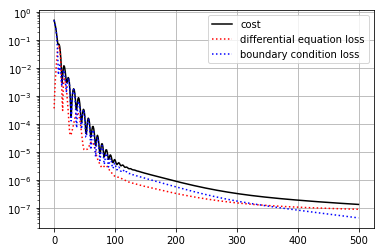

In [14]:
fig, ax = plt.subplots()
ax.plot(costHistory, "k", label="cost")
ax.plot(differentialEquationLossHistory, "r:", label="differential equation loss")
ax.plot(boundaryConditionLossHistory, "b:", label="boundary condition loss")
ax.set_yscale("log")
ax.grid()
ax.legend()
plt.show()

**displacement prediction**

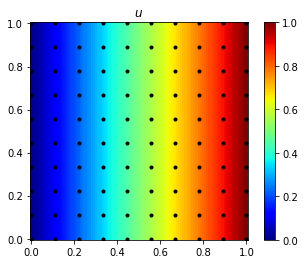

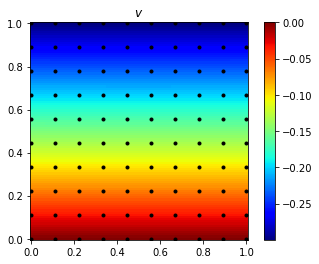

In [18]:
Nx_ = 100
Ny_ = 100
x_, y_, input_ = getGrid(Lx, Ly, Nx_, Ny_)

upred_ = getDisplacements(model, input_, strongEnforcementx, strongEnforcementy)
strain_ = getStrains(upred_, x_, y_, Nx_, Ny_)

fig, ax = plt.subplots()
cp = ax.pcolormesh(
    x_.detach(), y_.detach(), upred_[:, 0].reshape(Nx_, Ny_).detach(), cmap=plt.cm.jet, shading='auto'
)
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$u$")
plt.show()

fig, ax = plt.subplots()
cp = ax.pcolormesh(
    x_.detach(), y_.detach(), upred_[:, 1].reshape(Nx_, Ny_).detach(), cmap=plt.cm.jet, shading='auto'
)
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$v$")
plt.show()